In [51]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for timing computations
import time

# for data visualization
import matplotlib.pyplot as plt

import seaborn as sns

## Import Data

In [52]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
# data.describe()

In [53]:
## label - residual sugar
## feature - rest
## Drop the outliers in sulfer-dioxide column
data = data[data['total sulfur dioxide'] < 200].copy()

In [54]:
## Scale all feature columns
cols2zscore = data.columns
# cols2zscore = cols2zscore.drop(['residual sugar','quality'])
std = StandardScaler()
data[cols2zscore] = std.fit_transform(data[cols2zscore])

In [55]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03
mean,3.559388e-17,1.245786e-16,1.779694e-17,-9.788316e-17,-1.423755e-16,8.898469e-18,-5.339081e-17,-8.361001e-14,3.025479e-16,8.898469e-17,-5.695020e-16,4.182280e-16
std,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00
min,-2.136087e+00,-2.280762e+00,-1.391823e+00,-1.169149e+00,-1.604575e+00,-1.422837e+00,-1.262581e+00,-3.546932e+00,-3.709380e+00,-1.937318e+00,-1.899221e+00,-3.266852e+00
25%,-7.006076e-01,-7.718255e-01,-9.286769e-01,-4.525789e-01,-3.721412e-01,-8.478700e-01,-7.596977e-01,-6.111392e-01,-6.587444e-01,-6.392206e-01,-8.653154e-01,-7.866225e-01
50%,-2.412541e-01,-4.530063e-02,-5.384522e-02,-2.376079e-01,-1.809014e-01,-1.770746e-01,-2.568145e-01,-6.216372e-04,-9.673073e-03,-2.261897e-01,-2.073755e-01,4.534922e-01
75%,5.051954e-01,6.253377e-01,7.695258e-01,4.902022e-02,5.283609e-02,4.937208e-01,4.975104e-01,5.780428e-01,5.744912e-01,4.228588e-01,6.385471e-01,4.534922e-01
max,4.352281e+00,5.878672e+00,3.754246e+00,9.292776e+00,1.112349e+01,5.380944e+00,3.734821e+00,3.683719e+00,4.533826e+00,7.916418e+00,4.210221e+00,2.933721e+00


In [56]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].drop(['residual sugar'],axis=1).values ).float()
labels = torch.tensor( data['residual sugar'].values ).float()
labels = labels[:,None] # transform to matrix

In [57]:
# split the data into train and test dataset
train_data,test_data,train_labels,test_labels = train_test_split(dataT,labels,test_size=0.1,random_state=42)

In [58]:
#Convert the data into PyTorch DataLoaders
train_ds = TensorDataset(train_data, train_labels)
test_ds = TensorDataset(test_data, test_labels)

In [59]:
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_ds, batch_size = test_ds.tensors[0].shape[0])

## Create the ANN model

In [60]:
class ANNmodel(nn.Module):
  def __init__(self):
    super().__init__() # Added parentheses here

    ###input layer
    self.input = nn.Linear(in_features=11, out_features=16)

    ###hidden layers
    self.hidden1 = nn.Linear(in_features=16, out_features=32)
    self.hidden2 = nn.Linear(in_features=32, out_features=32)

    ###output layer
    self.output = nn.Linear(in_features=32, out_features=1)

  ###forward pass
  def forward(self,x):
    x = F.relu(self.input(x)) #Activation function for input layer
    x = F.relu(self.hidden1(x)) #Activation function for hidden layer 1
    x = F.relu(self.hidden2(x)) # Activation function for hidden layer 2
    x = self.output(x)
    return x

## Train the model

In [61]:
# a function that trains the model
def trainTheModel(numepochs=1000):
  model = ANNmodel()

  # loss function and optimizer
  lossfun = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(),lr=.01)

  # initialize losses
  train_losses   = torch.zeros(numepochs)
  test_losses    = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    model.train()

    # loop over training data batches
    batchAcc  = []
    train_batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = model(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      train_batchLoss.append(loss.item())

    # end of batch loop...


    # and get average losses across the batches
    train_losses[epochi] = np.mean(train_batchLoss)

    # test accuracy
    model.eval()
    test_batchLoss = []
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = model(X)

    test_losses[epochi] = lossfun(yHat,y).item()

  # function output
  return train_losses,test_losses

In [62]:
# initialize output results matrices
numepochs = 1000

# create and train a model

train_losses,test_losses = trainTheModel(numepochs)

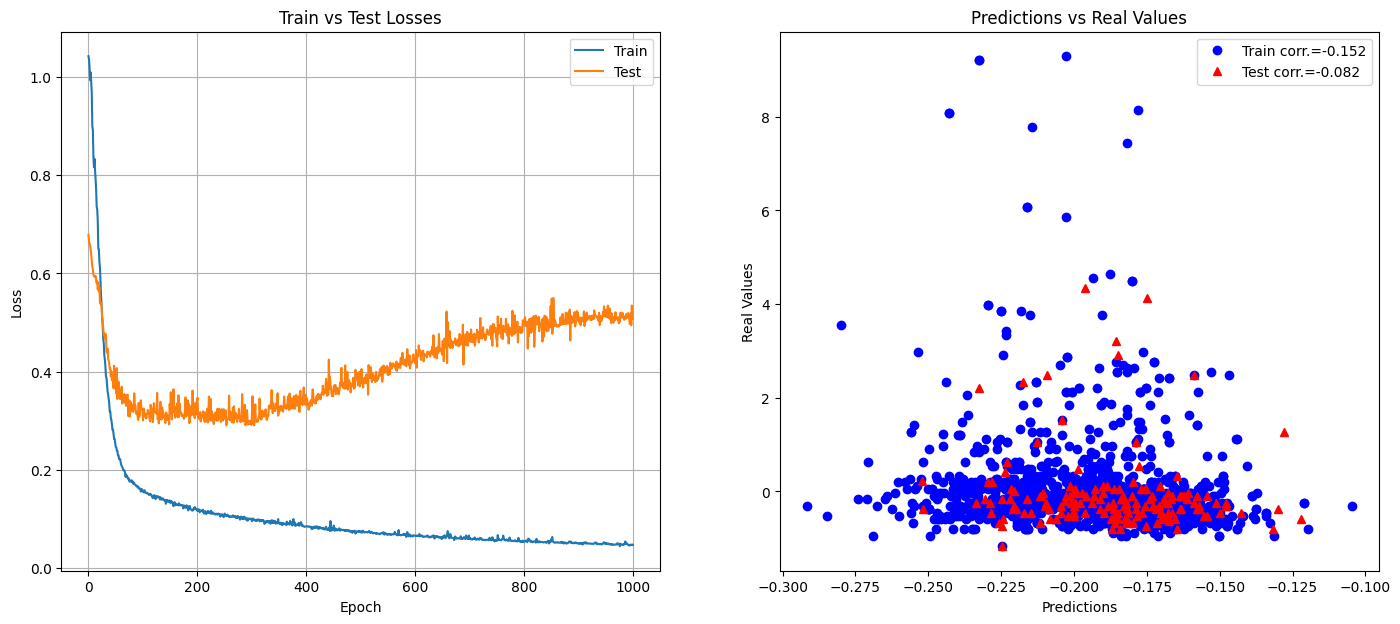

In [63]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(train_losses)
ax[0].plot(test_losses)
ax[0].set_title('Train vs Test Losses')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(['Train','Test'])
ax[0].grid()

#Plot for predictions vs real values
model = ANNmodel()
yHat_train = model(train_data)
yHat_test  = model(test_data)

ax[1].plot(yHat_train.detach().numpy(),train_labels,'bo',label='Train')
ax[1].plot(yHat_test.detach().numpy(),test_labels,'r^',label='Test')
ax[1].set_title('Predictions vs Real Values')
ax[1].set_xlabel('Predictions')
ax[1].set_ylabel('Real Values')


#correlations between predictions and real values
corr_train = np.corrcoef(yHat_train.detach().numpy().T,train_labels.detach().numpy().T)[1,0]
corr_test  = np.corrcoef(yHat_test.detach().numpy().T,test_labels.detach().numpy().T)[1,0]
ax[1].legend([f'Train corr.={corr_train:.3f}',f'Test corr.={corr_test:.3f}'])

plt.show();

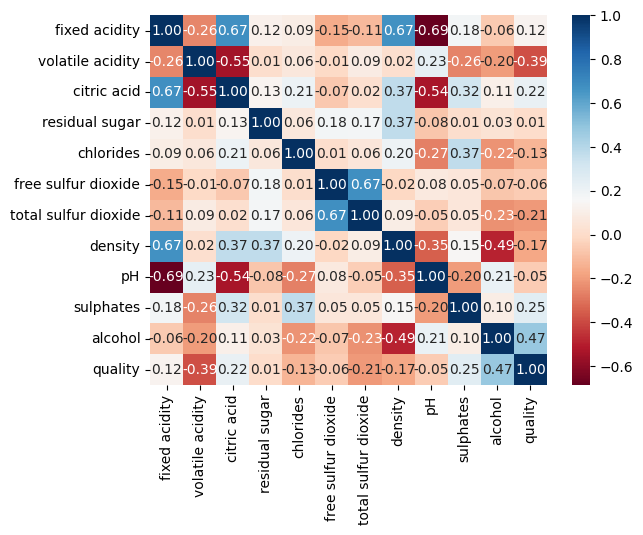

In [64]:
corr_mat=data.corr()
sns.heatmap(corr_mat,fmt='0.2f',cmap='RdBu',annot=True)
plt.show();

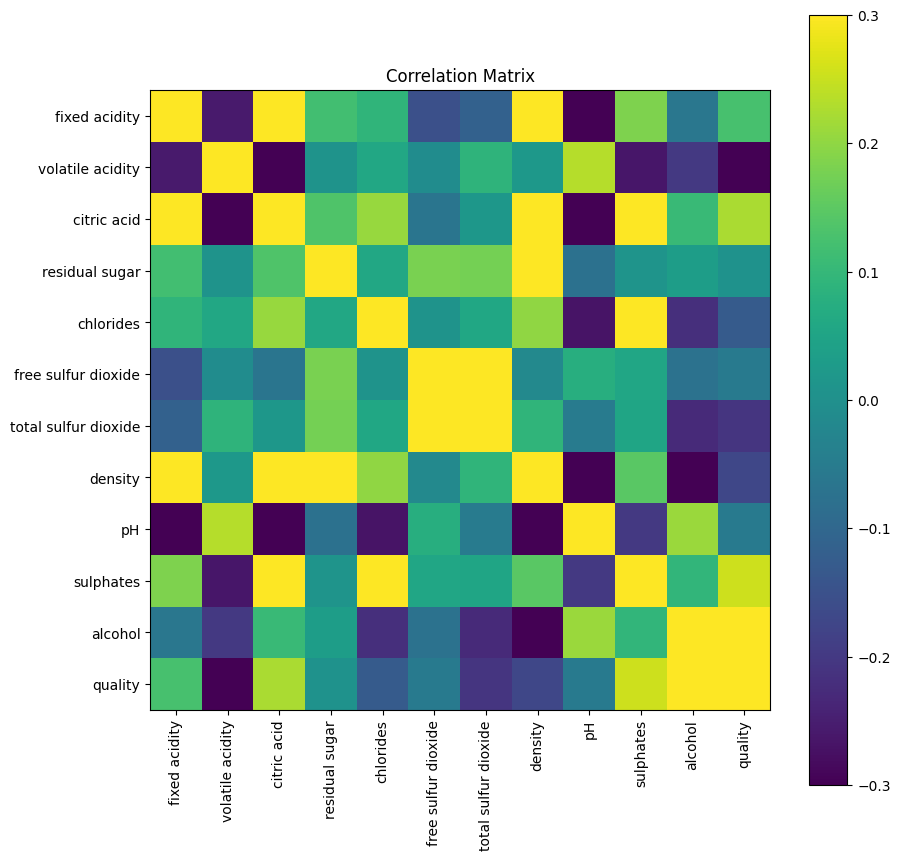

In [65]:
fig = plt.figure(figsize=(10,10))

plt.imshow(np.corrcoef(data.T),vmin=-.3,vmax=.3)
plt.xticks(range(len(data.columns)),data.columns,rotation=90)
plt.yticks(range(len(data.columns)),data.columns)
plt.colorbar()
plt.title('Correlation Matrix')
plt.show();